In [30]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import scipy.io as sio
import pandas as pd
import datetime
import xarray as xr
from salishsea_tools import tidetools, geo_tools, viz_tools
import ONC_patrols as onc
import matplotlib.lines as mlines

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

%matplotlib inline

In [2]:
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
bathy, X, Y = tidetools.get_bathy_data(grid)

In [3]:
nowcast = xr.open_dataset(
    'https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSg3DTracerFields1hV17-02')

In [4]:
nowcast_salinity = nowcast.salinity
nowcast_temperature = nowcast.temperature

In [5]:
mesh = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/mesh_mask201702.nc')
tmask = mesh.variables['tmask'][:]

In [6]:
ctd_2015 = sio.loadmat('/ocean/rich/home/metro/venus_adcp/matlabPSF/CitSci_Final.mat')
ctd_2016 = sio.loadmat('/ocean/rich/home/metro/venus_adcp/matlabPSF/CitSci_Final2016.mat')

In [7]:
ctd_2015_data = ctd_2015[list(ctd_2015.keys())[3]]
ctd_2016_data = ctd_2016[list(ctd_2016.keys())[3]]

In [8]:
ctd_2015_dtype = ctd_2015_data.dtype
ctd_2016_dtype = ctd_2016_data.dtype

In [9]:
ctd2015data = {n: ctd_2015_data[n][0, 0] for n in ctd_2015_dtype.names}
ctd2016data = {n: ctd_2016_data[n][0, 0] for n in ctd_2016_dtype.names}

In [10]:
print(ctd2015data.keys())
print(ctd2016data.keys())

dict_keys(['patrol', 'ID', 'stn', 'mtime', 'lat', 'long', 'pr', 'mtimes', 'temp', 'sal', 'cond', 'depth', 'stnN', 'o2', 'chl', 'comment'])
dict_keys(['patrol', 'ID', 'stn', 'mtime', 'lat', 'long', 'pr', 'mtimes', 'temp', 'sal', 'cond', 'depth', 'stnN', 'o2SAT', 'o2uM', 'chl', 'comment'])


In [11]:
Stn2015 = ctd2015data['stnN'][0,:]

In [12]:
Stn2016 = ctd2016data['stnN'][0,:]

In [13]:
ID_2015 = np.array([ctd2015data['ID'][0,:][n][0] for n in range(2142)])
ID_2016 = np.array([ctd2016data['ID'][0,:][n][0] for n in range(1165)])

In [14]:
patrol_2015 = np.array([ctd2015data['patrol'][0,:]])
patrol_2016 = np.array([ctd2016data['patrol'][0,:]])

In [15]:
ctd2016data['lat'][0,:].shape

(1165,)

In [16]:
ctd2015data['long'][0,:].shape

(2142,)

In [17]:
base = datetime.datetime(2000, 1, 1)
dates_2015 = np.array([])
py_ctd_2015_times = np.array([base for i in range(2142)])
for n in range(2142):
    a = ((datetime.datetime.fromordinal(int(ctd2015data['mtime'][0,:][n])))
         + datetime.timedelta(days=ctd2015data['mtime'][0,:][n]%1)
         - datetime.timedelta(days = 366))
    py_ctd_2015_times[n] = a
    dates_2015 = np.append(dates_2015, datetime.date(a.year, a.month, a.day))
py_ctd_2016_times = np.array([base for i in range(1165)])
dates_2016 = np.array([])
for n in range(1165):
    b = ((datetime.datetime.fromordinal(int(ctd2016data['mtime'][0,:][n])))
         + datetime.timedelta(days=ctd2016data['mtime'][0,:][n]%1)
         - datetime.timedelta(days = 366))
    py_ctd_2016_times[n] = b
    dates_2016 = np.append(dates_2016, datetime.date(b.year, b.month, b.day))

In [18]:
data = {'mtime' : np.append(ctd2015data['mtime'][0,:], ctd2016data['mtime'][0,:]),
        'lat' : np.append(ctd2015data['lat'][0,:], ctd2016data['lat'][0,:]),
        'lon' : np.append(ctd2015data['long'][0,:], ctd2016data['long'][0,:]),
        'ID' : np.append(ID_2015, ID_2016),
        'patrol': np.append(patrol_2015, patrol_2016),
        'time': np.append(py_ctd_2015_times, py_ctd_2016_times),
        'date': np.append(dates_2015, dates_2016),
        'station': np.append(Stn2015, Stn2016)}
stationdata = pd.DataFrame(data)
stationdata[:10]

,ID,date,lat,lon,mtime,patrol,station,time
0,PSFLND2015-02-16_01,2015-02-16,49.986738,-124.822141,736011.697907,1,1,2015-02-16 16:44:59.124996
1,PSFLND2015-02-16_02,2015-02-16,49.986782,-124.822243,736011.702466,1,1,2015-02-16 16:51:33.055559
2,PSFLND2015-02-16_03,2015-02-16,49.961587,-124.856736,736011.727781,1,2,2015-02-16 17:28:00.277814
3,PSFLND2015-02-16_04,2015-02-16,49.960653,-124.856381,736011.733140,1,2,2015-02-16 17:35:43.314781
4,PSFLND2015-02-16_05,2015-02-16,50.078240,-124.868398,736011.785290,1,4,2015-02-16 18:50:49.041700
5,PSFLND2015-02-16_06,2015-02-16,50.077821,-124.868130,736011.791713,1,4,2015-02-16 19:00:03.987151
6,PSFLND2015-02-16_07,2015-02-16,50.100239,-124.739698,736011.847963,1,7,2015-02-16 20:21:03.970587
7,PSFLND2015-02-16_08,2015-02-16,50.100432,-124.740207,736011.854413,1,7,2015-02-16 20:30:21.264697
8,PSFLND2015-02-16_09,2015-02-16,50.083331,-124.789848,736011.870040,1,8,2015-02-16 20:52:51.466668
9,PSFLND2015-02-16_10,2015-02-16,50.083181,-124.789804,736011.876294,1,8,2015-02-16 21:01:51.833360


In [19]:
Lund = stationdata.loc[stationdata['patrol'] == 1]

In [20]:
Lund.shape

(456, 8)

In [21]:
Lund_one_day = Lund.loc[Lund['date'] == Lund['date'].unique()[3]]
print(Lund_one_day.shape)

(16, 8)


In [22]:
masked_2015_depths = np.ma.masked_invalid(ctd2015data['depth'])
masked_2015_sals = np.ma.masked_invalid(ctd2015data['sal'])
masked_2015_temps = np.ma.masked_invalid(ctd2015data['temp'])
masked_2016_depths = np.ma.masked_invalid(ctd2016data['depth'])
masked_2016_sals = np.ma.masked_invalid(ctd2016data['sal'])
masked_2016_temps = np.ma.masked_invalid(ctd2016data['temp'])

In [23]:
masked_depths = np.ma.masked_array(np.zeros((200,3307)), mask = True)
masked_sals = np.ma.masked_array(np.zeros((200,3307)), mask = True)
masked_temps = np.ma.masked_array(np.zeros((200,3307)), mask = True)
for n in range(2142):
    masked_depths[:, n].mask = masked_2015_depths[:200,n].mask
    masked_depths[:,n] = masked_2015_depths[:200,n]
    masked_sals[:,n].mask = masked_2015_sals[:200,n].mask
    masked_sals[:,n] = masked_2015_sals[:200,n]
    masked_temps[:,n].mask = masked_2015_temps[:200,n].mask
    masked_temps[:,n] = masked_2015_temps[:200,n]
for n in range(1165):
    masked_depths[:, n+2142].mask = masked_2016_depths[:,n].mask
    masked_depths[:,n+2142] = masked_2016_depths[:,n]
    masked_sals[:,n+2142].mask = masked_2016_sals[:,n].mask
    masked_sals[:,n+2142] = masked_2016_sals[:,n]
    masked_temps[:,n+2142].mask = masked_2016_temps[:,n].mask
    masked_temps[:,n+2142] = masked_2016_temps[:,n]

In [24]:
deptht = nowcast.depth.values

In [49]:
def compare_one_day(patrolonlydata):
    fig, ax = plt.subplots(1,2, figsize = (21,8))
    end_index = patrolonlydata.shape[0]
    list_of_model_sal = np.ma.masked_array(np.zeros((200,end_index)), mask = True)
    m = 0
    for index in patrolonlydata.index:
        Yind, Xind = geo_tools.find_closest_model_point(patrolonlydata.loc[[index]]['lon'].values[0],
                                                       patrolonlydata.loc[[index]]['lat'].values[0], 
                                                       X, Y, land_mask = bathy.mask)
        date = pd.Timestamp(patrolonlydata.loc[[index]]['time'].values[0]).to_pydatetime()
        for n in range(200):
            if masked_sals.mask[n, index] == False:
                land = np.abs((deptht - masked_depths[n, index])).argmin()
                if tmask[0,land,Yind,Xind] == 1:
                    if date.minute < 30:
                        before = datetime.datetime(year = date.year, month = date.month, 
                                                   day = date.day, hour = (date.hour), 
                                                   minute = 30) - datetime.timedelta(hours=1)
                        delta = (date - before).seconds / 3600
                        s_val = (delta * ((nowcast_salinity
                               .sel(time = before, depth = masked_depths[n, index], 
                                    method = 'nearest')
                               .isel(gridY = Yind, gridX = Xind)).values) + 
                               (1- delta)*((nowcast_salinity
                               .sel(time = before + datetime.timedelta(hours=1), 
                                    depth = masked_depths[n, index], method = 'nearest')
                               .isel(gridY = Yind, gridX = Xind)).values))
                    if date.minute >= 30:
                        before = datetime.datetime(year = date.year, month = date.month, 
                                                   day = date.day, 
                                                   hour = (date.hour), minute = 30)
                        delta = (date - before).seconds / 3600
                        s_val = (delta * ((nowcast_salinity
                               .sel(time = before, depth = masked_depths[n,index], 
                                    method = 'nearest')
                               .isel(gridY = Yind, gridX = Xind)).values) + 
                               (1- delta)*((nowcast_salinity
                               .sel(time = before + datetime.timedelta(hours=1), 
                                    depth = masked_depths[n,index], method = 'nearest')
                               .isel(gridY = Yind, gridX = Xind)).values))
                    list_of_model_sal[n, m].mask = False
                    list_of_model_sal[n, m] = s_val
        m = m + 1
    
    #depth profile
    k = 0
    for n in patrolonlydata.index:
        ax[0].plot(np.ma.masked_invalid(masked_sals[:,n]), 
                  np.ma.masked_invalid(masked_depths[:,n]), 
                  '*', c='blue', alpha = 0.5)
        ax[0].plot(list_of_model_sal[:,k], 
                   np.ma.masked_invalid(masked_depths[:,k]), 
                 linestyle='-', c='green', alpha = 0.5)
        k = k + 1
    blue_line = mlines.Line2D([], [], color='green')
    gray_line = mlines.Line2D([], [], color='blue')
    fig.legend(handles=[blue_line, gray_line], labels = ['Nowcast-green', 'Citizen Science']);
    ax[0].set_ylim(150,0)
    ax[0].set_ylabel('Depth (m)')
    ax[0].set_xlabel('Salinity')    
    ax[0].set_title(date)
      
    #map
    Yinds = np.array([])
    Xinds = np.array([])
    for n in patrolonlydata['station'].unique():
        Yind, Xind = geo_tools.find_closest_model_point(
            patrolonlydata.loc[patrolonlydata['station'] == n].iloc[0]['lon'],
            patrolonlydata.loc[patrolonlydata['station'] == n].iloc[0]['lat'],X, Y, land_mask = bathy.mask)
        Yinds = np.append(Yinds, Yind)
        Xinds = np.append(Xinds, Xind)
    ax[1].plot(Xinds, Yinds, '*', color = 'teal', markersize = 20)
    viz_tools.plot_coastline(ax[1], grid)
    ax[1].set_ylim(np.amax(np.array([0, np.amin(Yinds) - 50])), np.amin(np.array([898, np.amax(Yinds) + 50])))
    ax[1].set_xlim(np.amax(np.array([0, np.amin(Xinds) - 50])), np.amin(np.array([398, np.amax(Xinds) + 50])))
    viz_tools.set_aspect(ax[1])
    
    return ax

In [51]:
stations = np.random.randint(0, 3307, size = ((20, )))

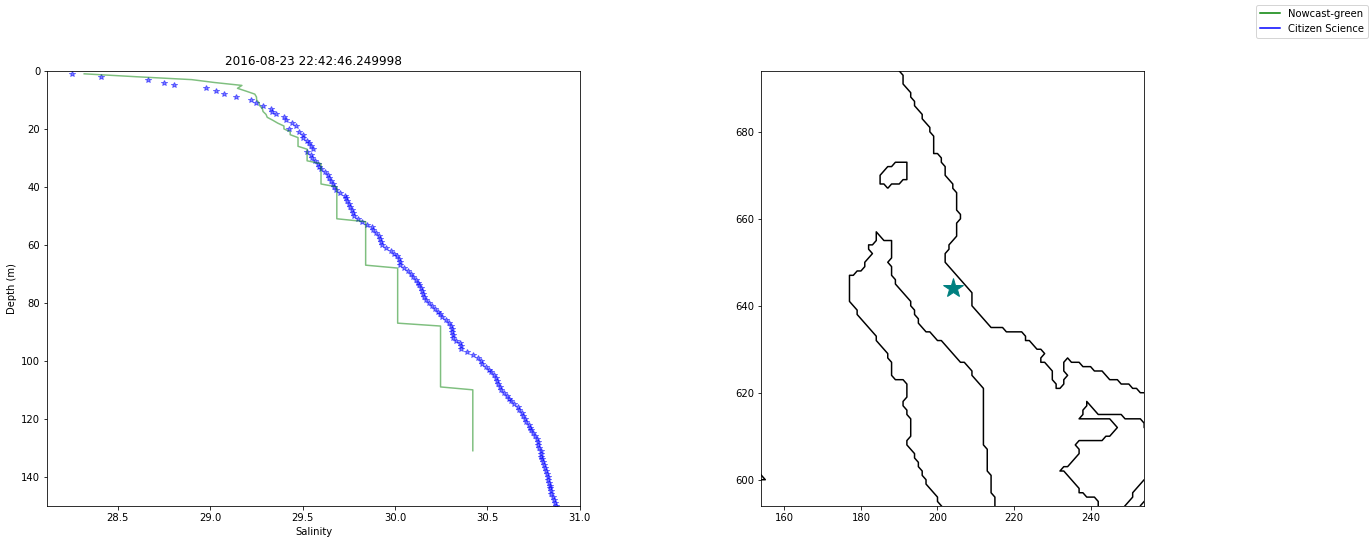

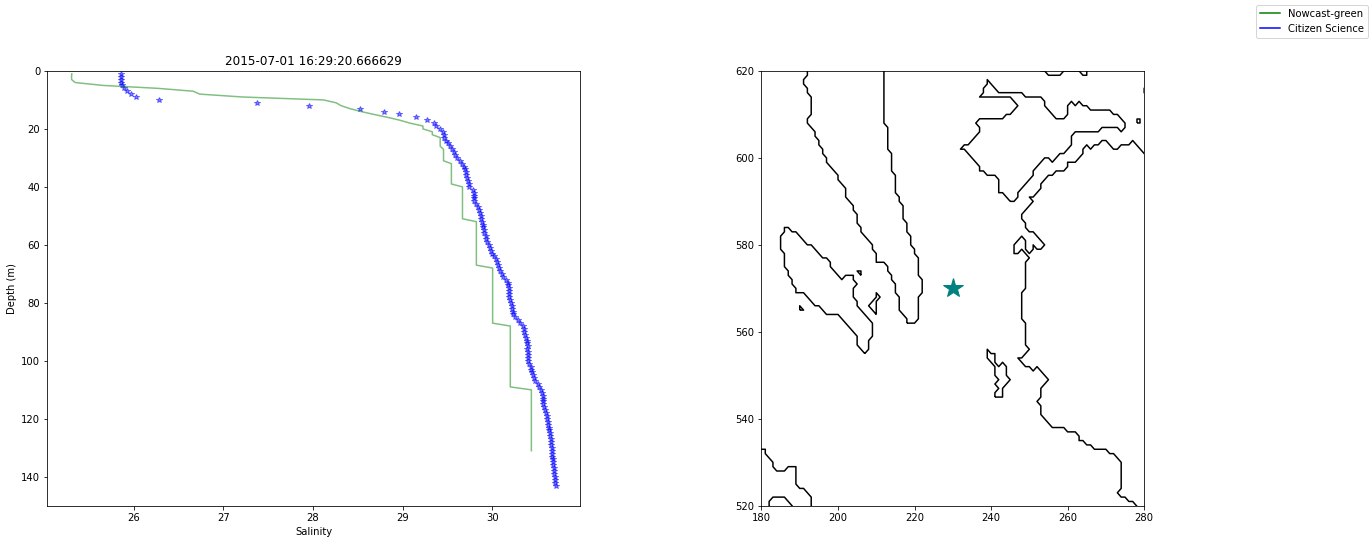

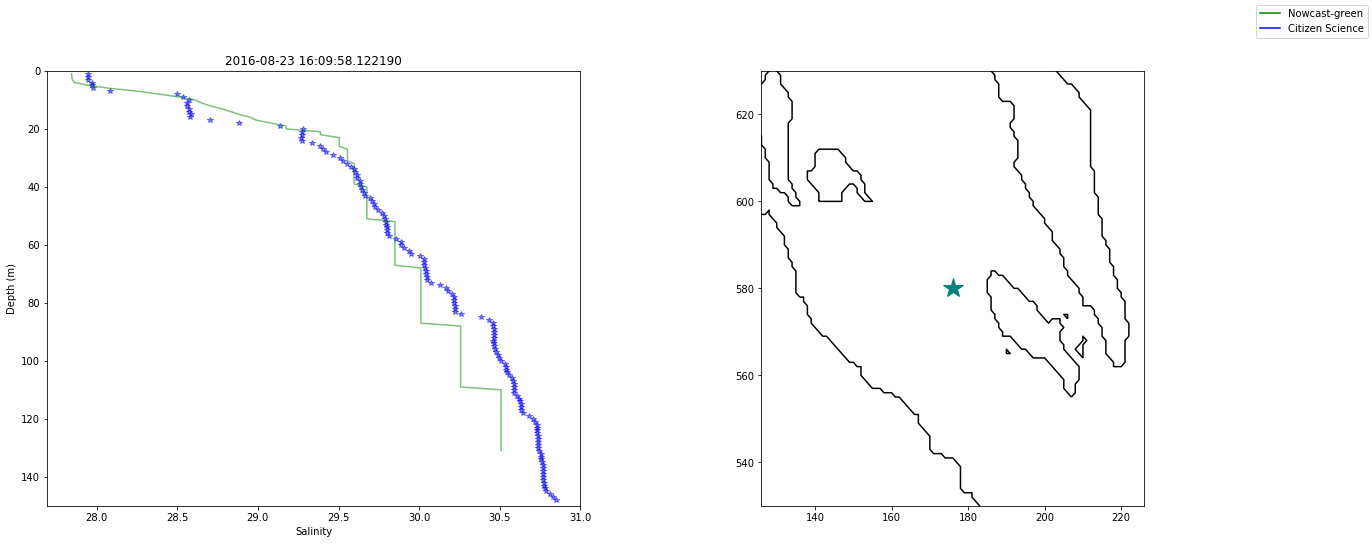

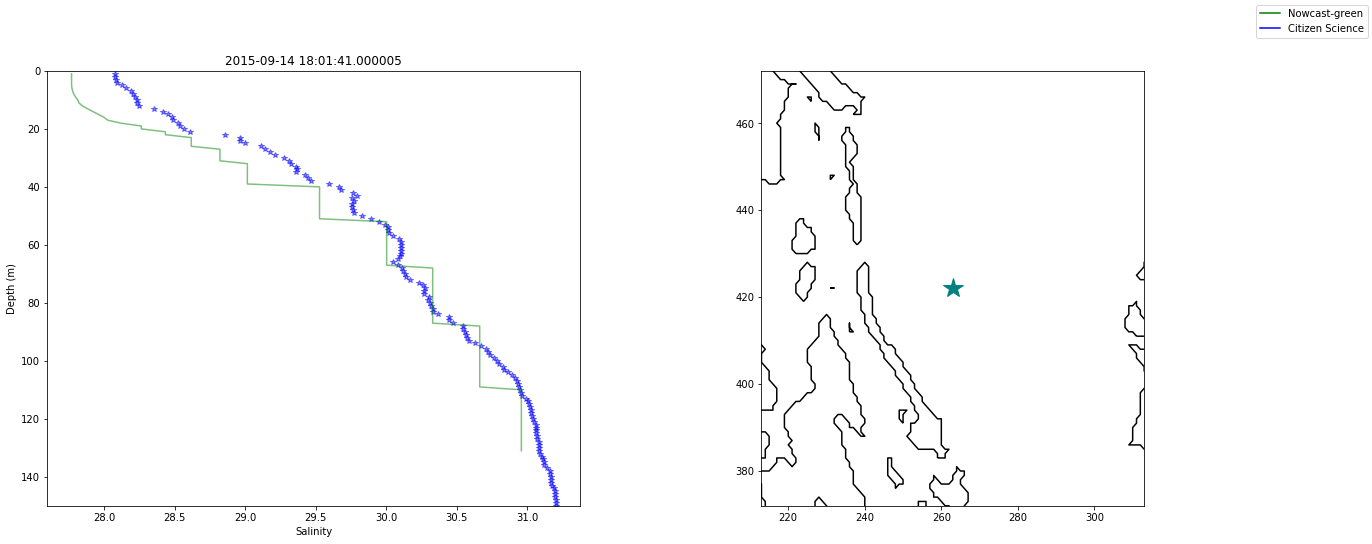

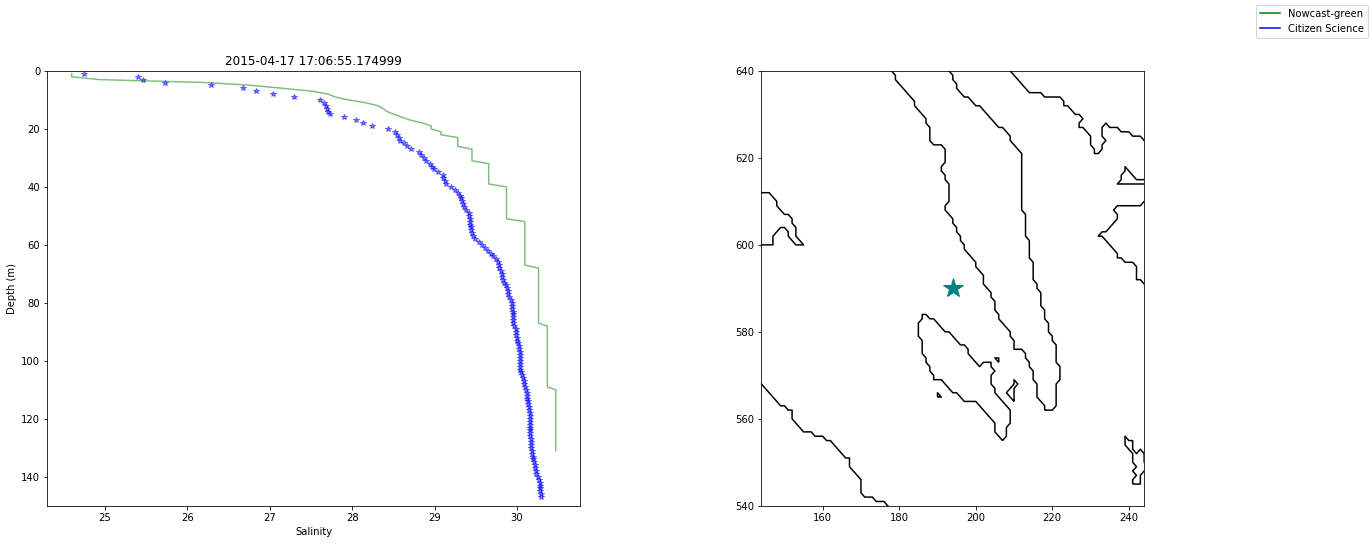

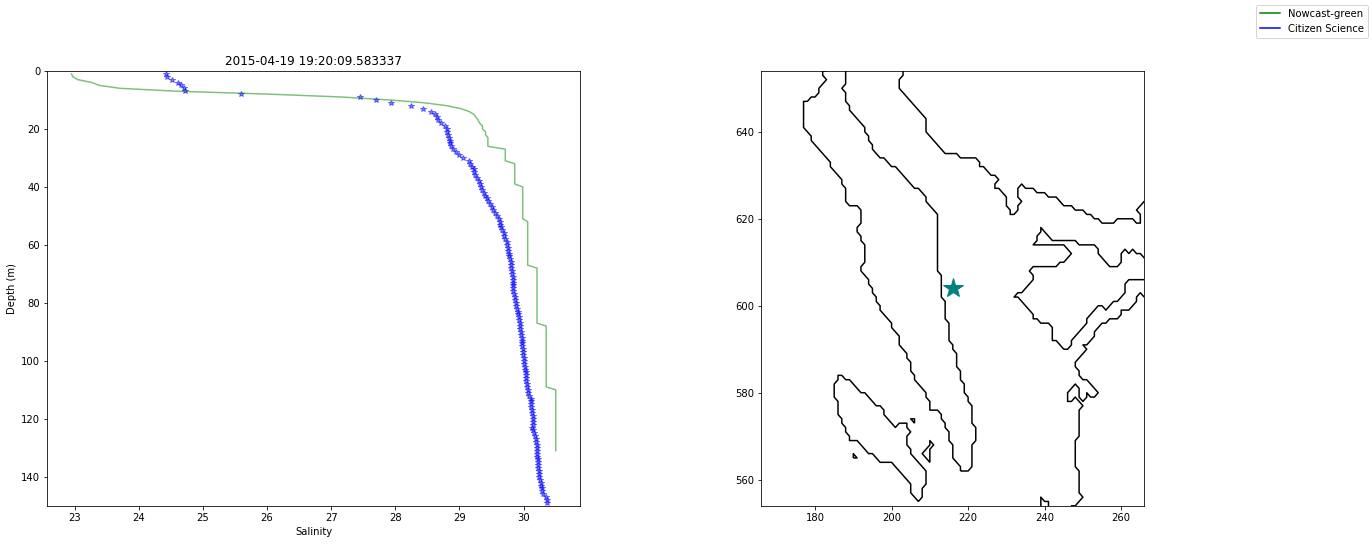

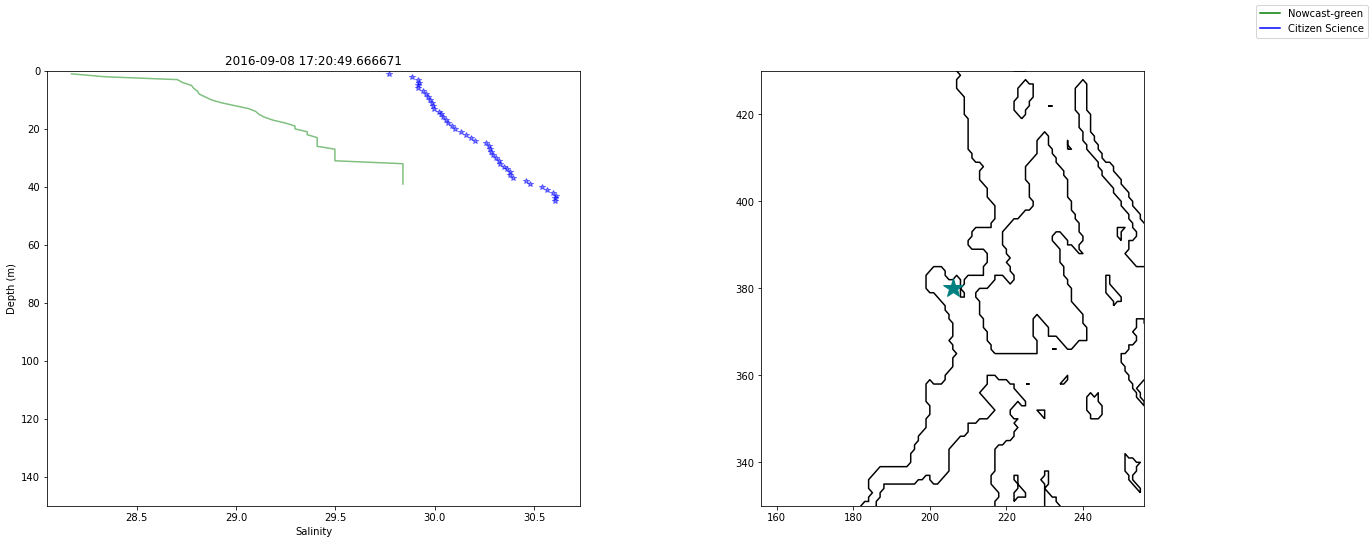

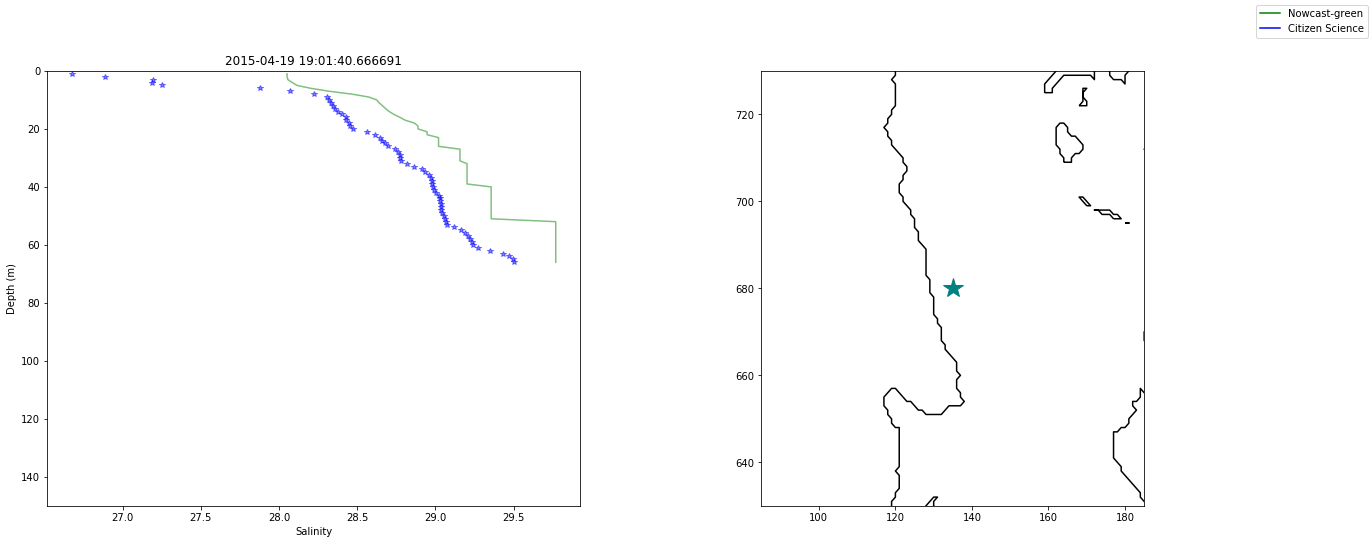

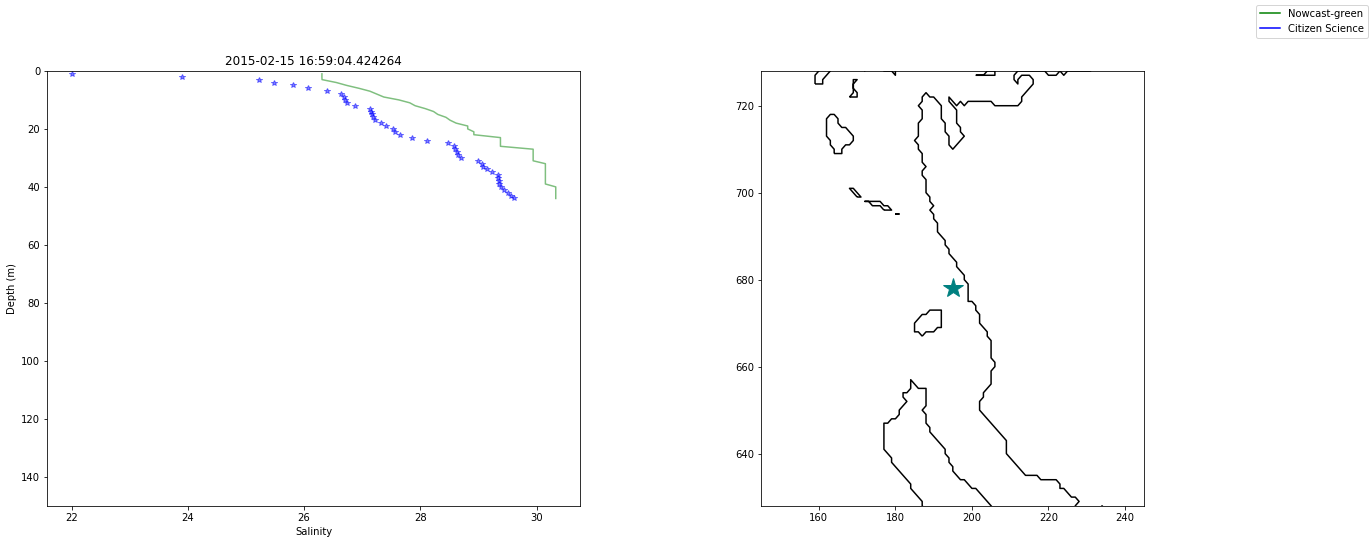

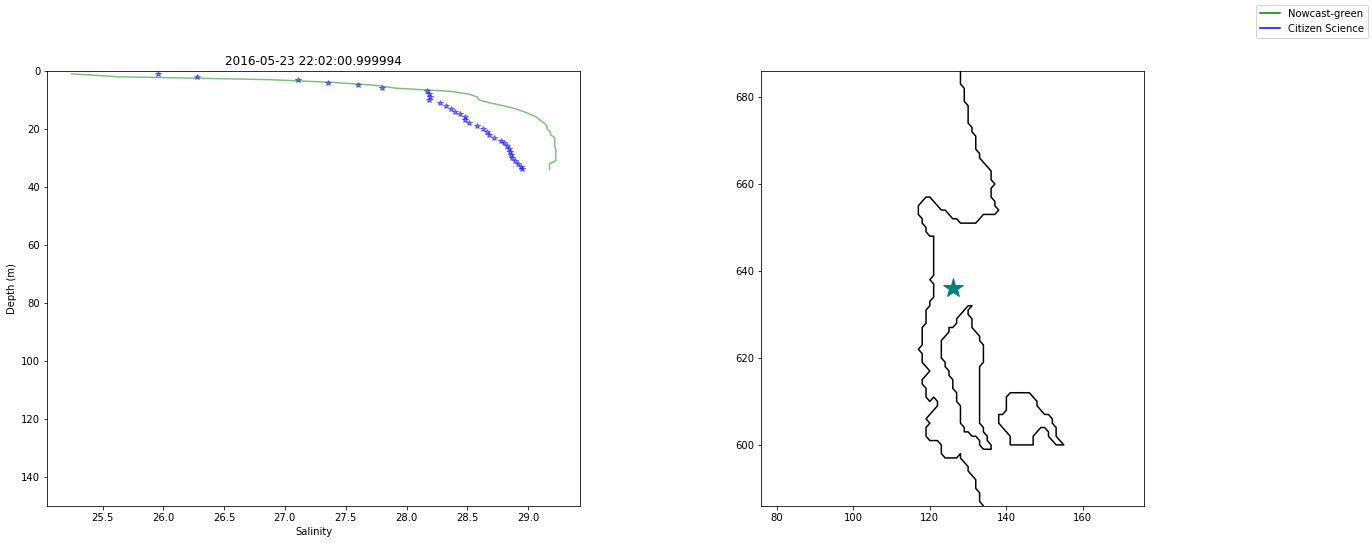

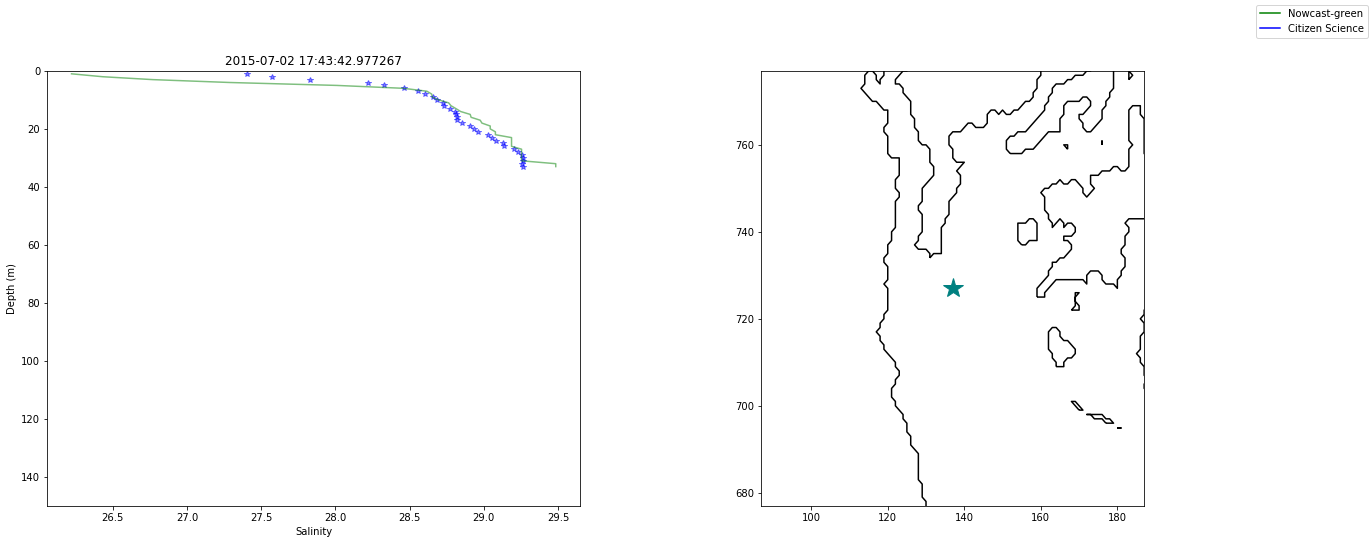

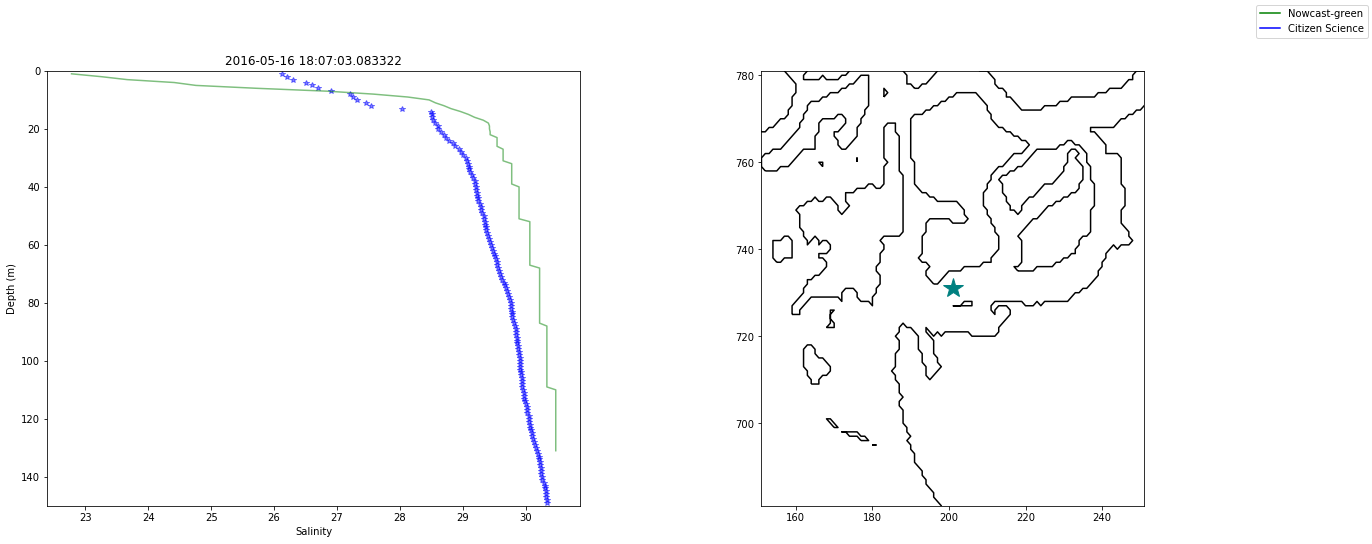

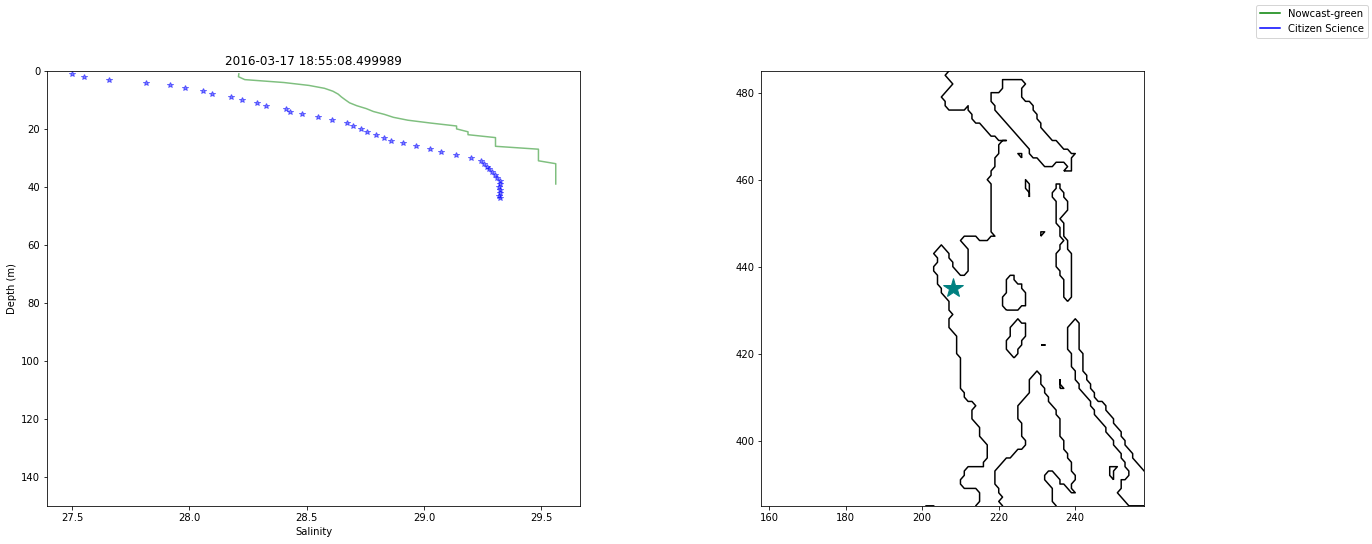

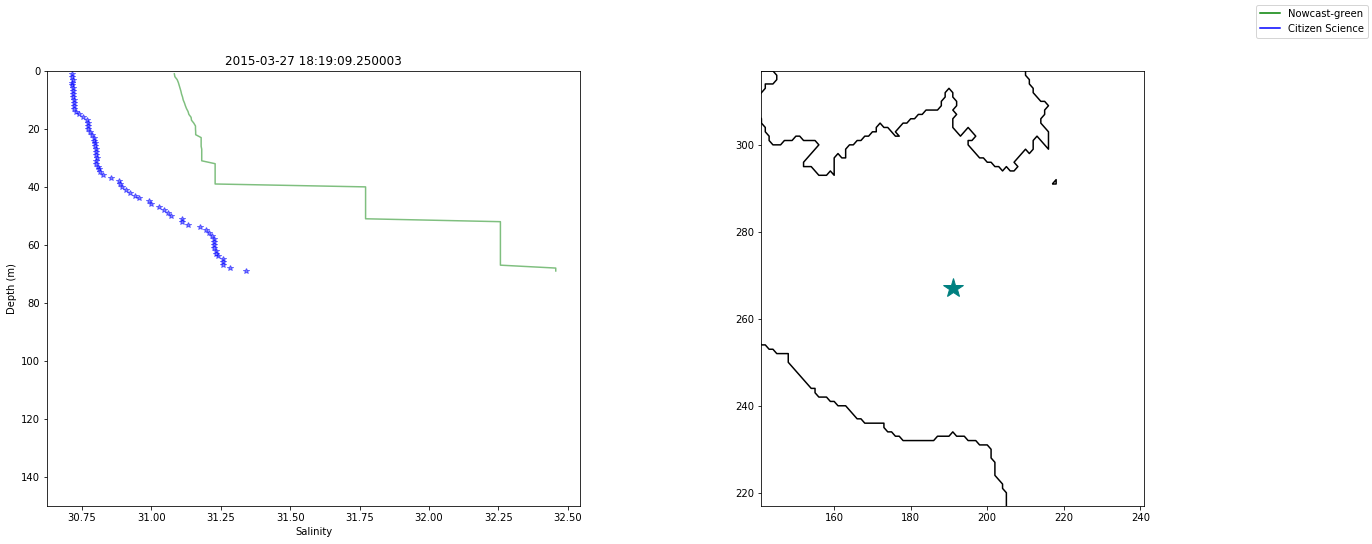

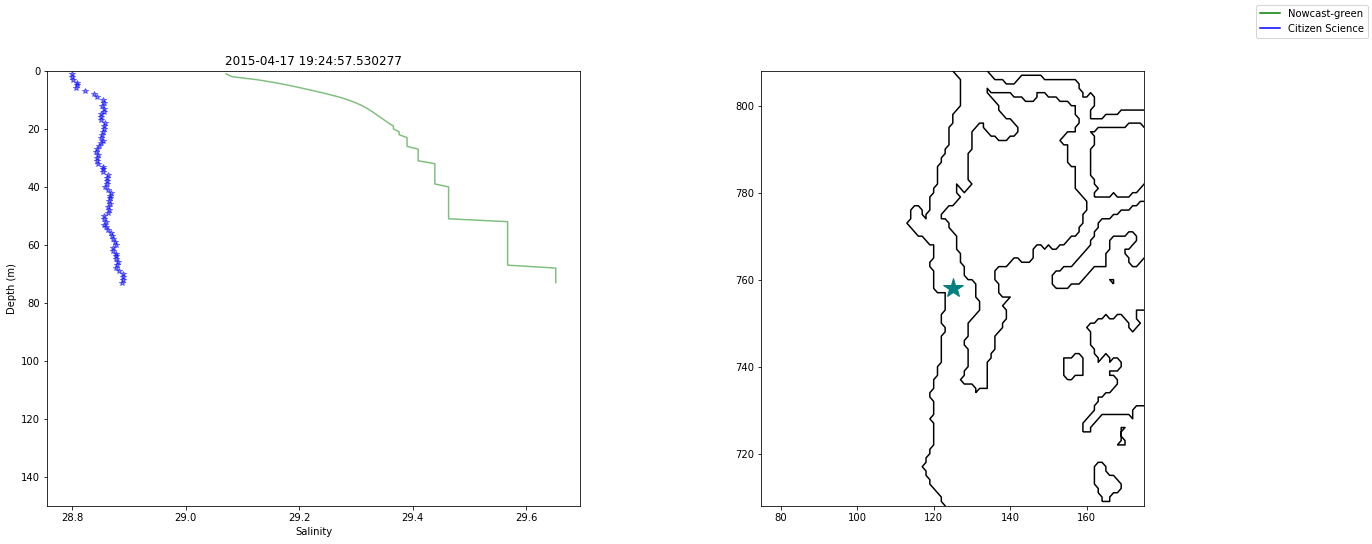

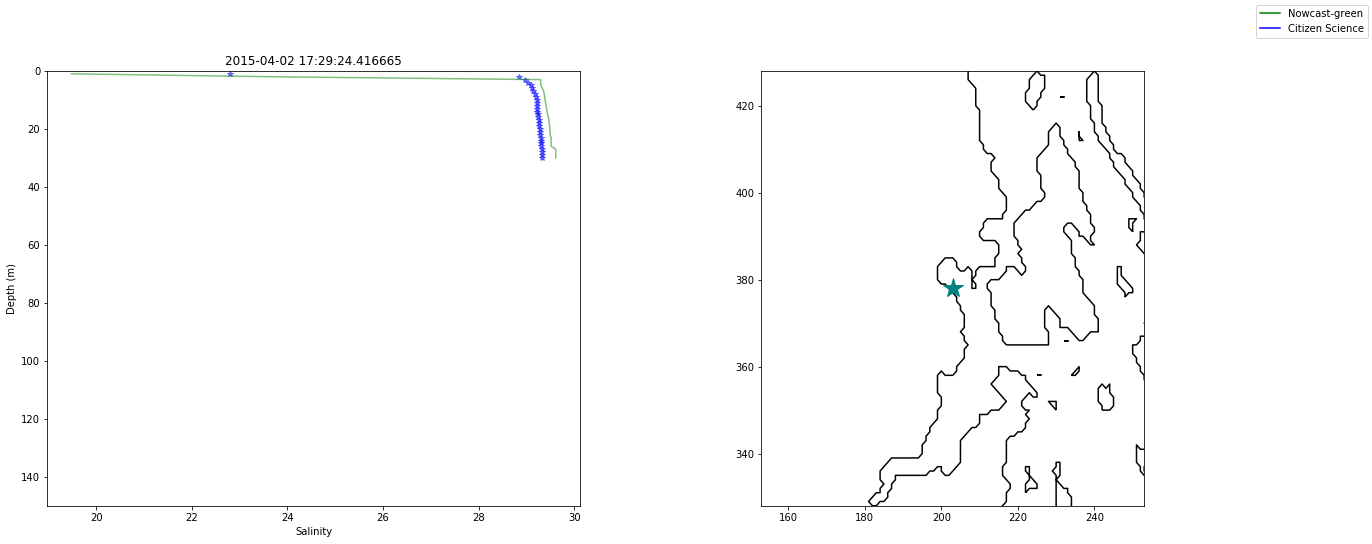

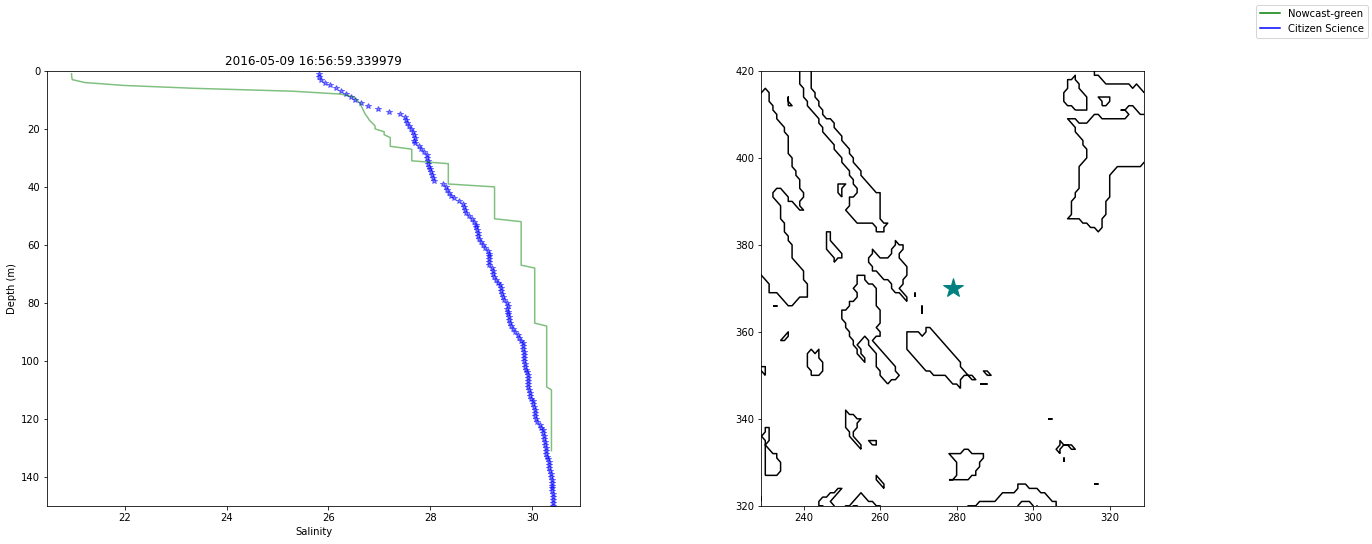

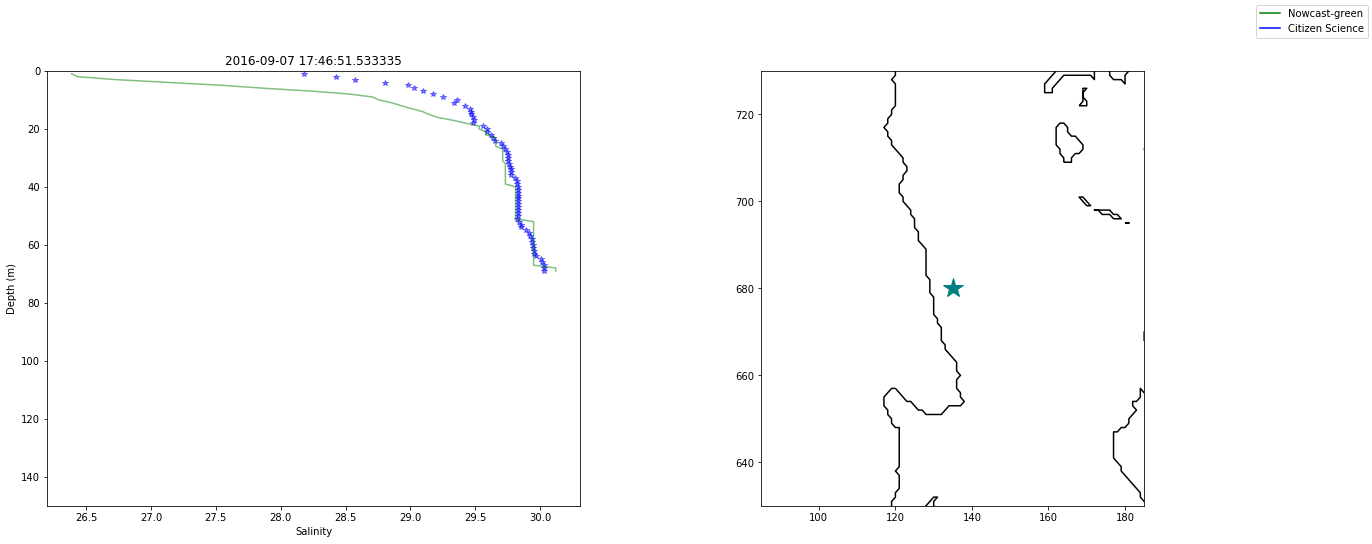

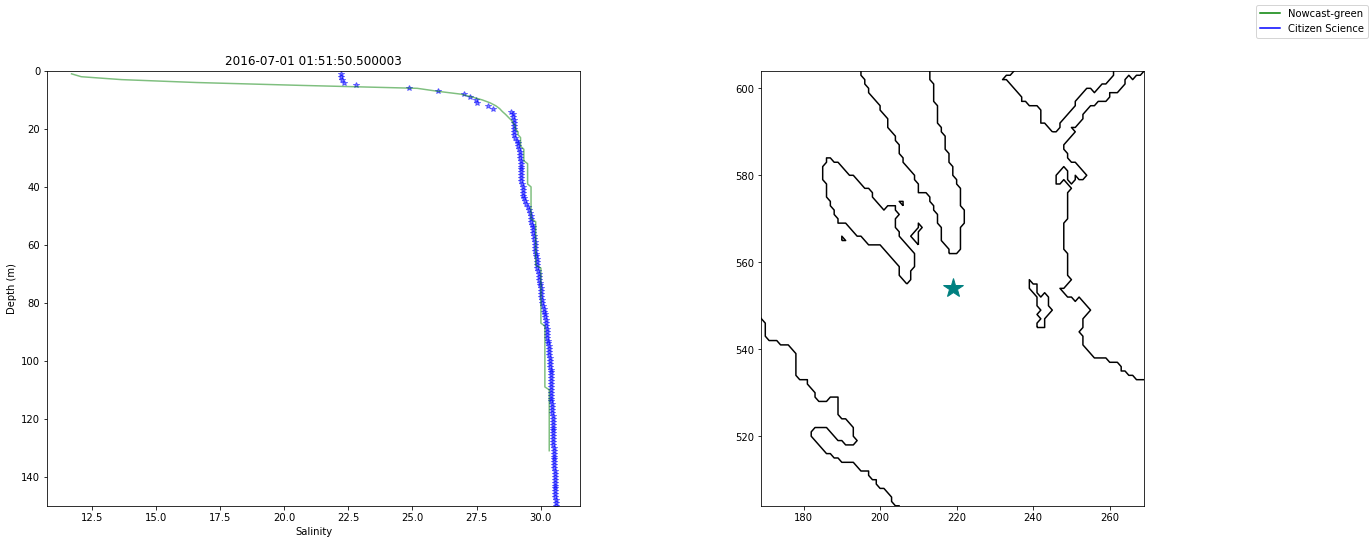

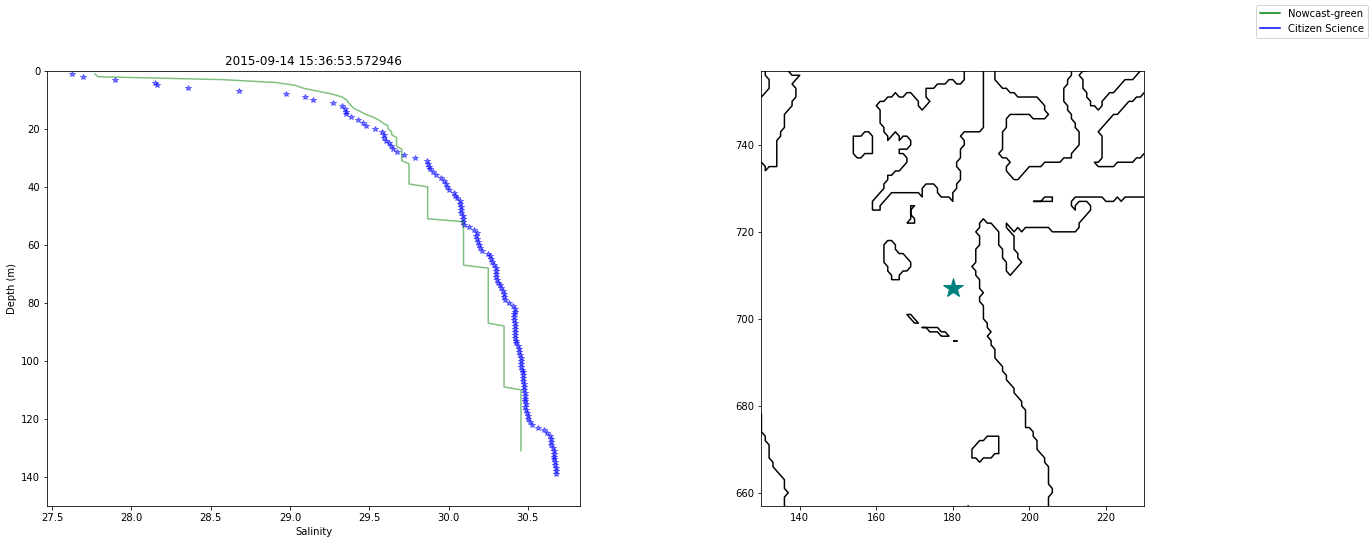

In [52]:
for index in stations:
    compare_one_day(stationdata.iloc[[index]])

In [70]:
stevestons_stations = stationdata.loc[(stationdata['patrol'] == 8)].index

In [83]:
stations = np.random.choice(stevestons_stations[93:], size = (5, ))

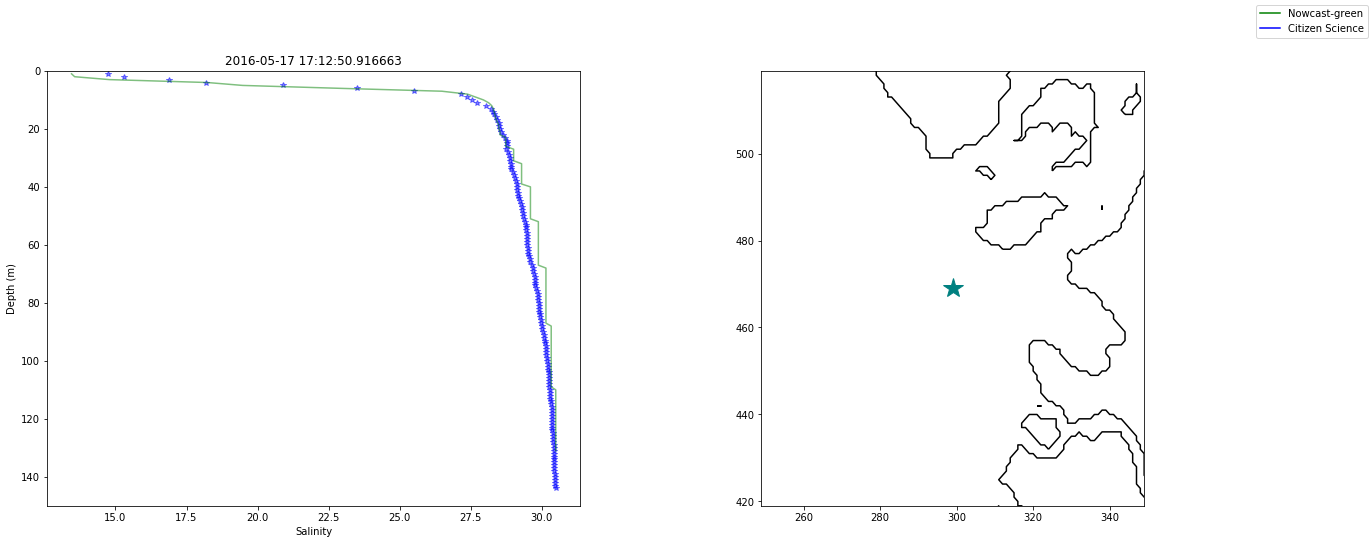

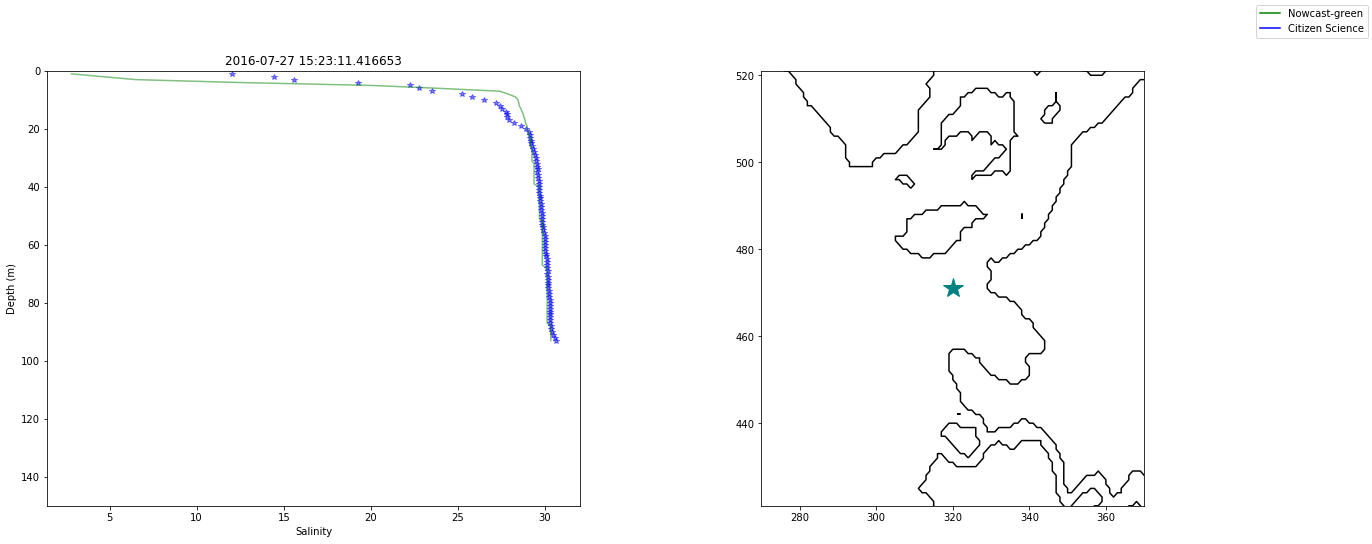

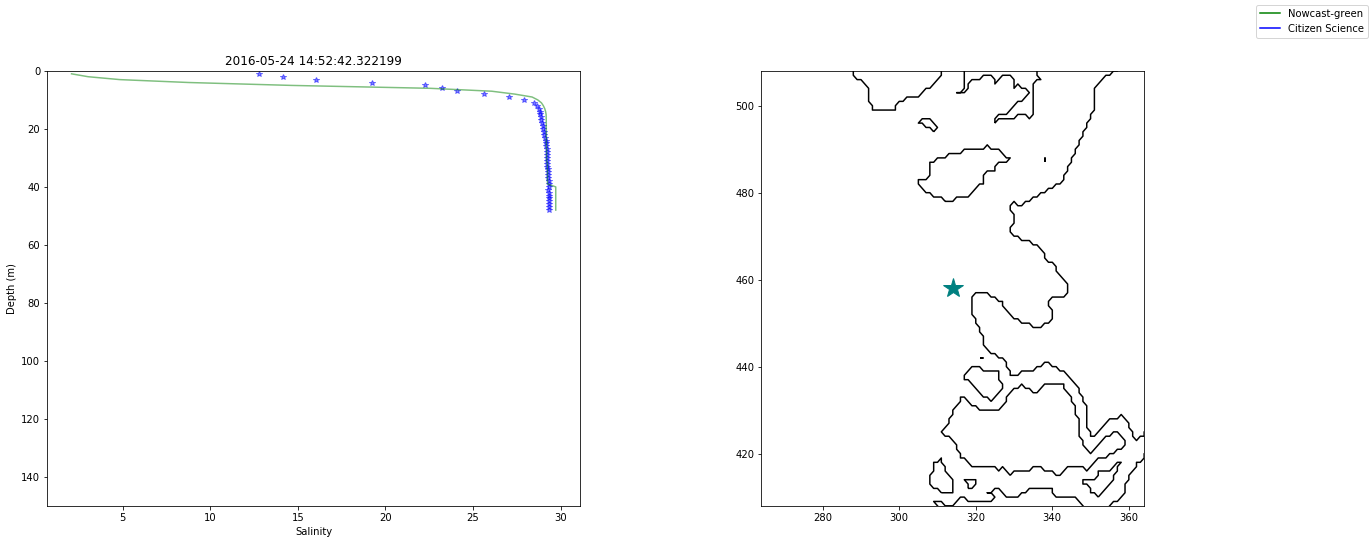

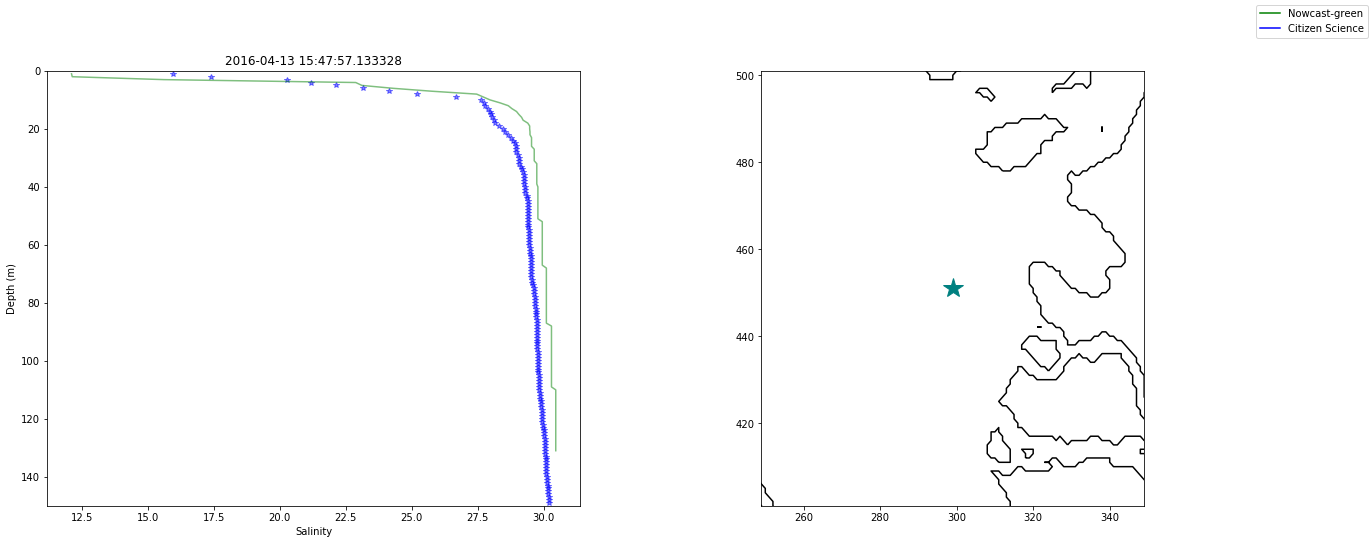

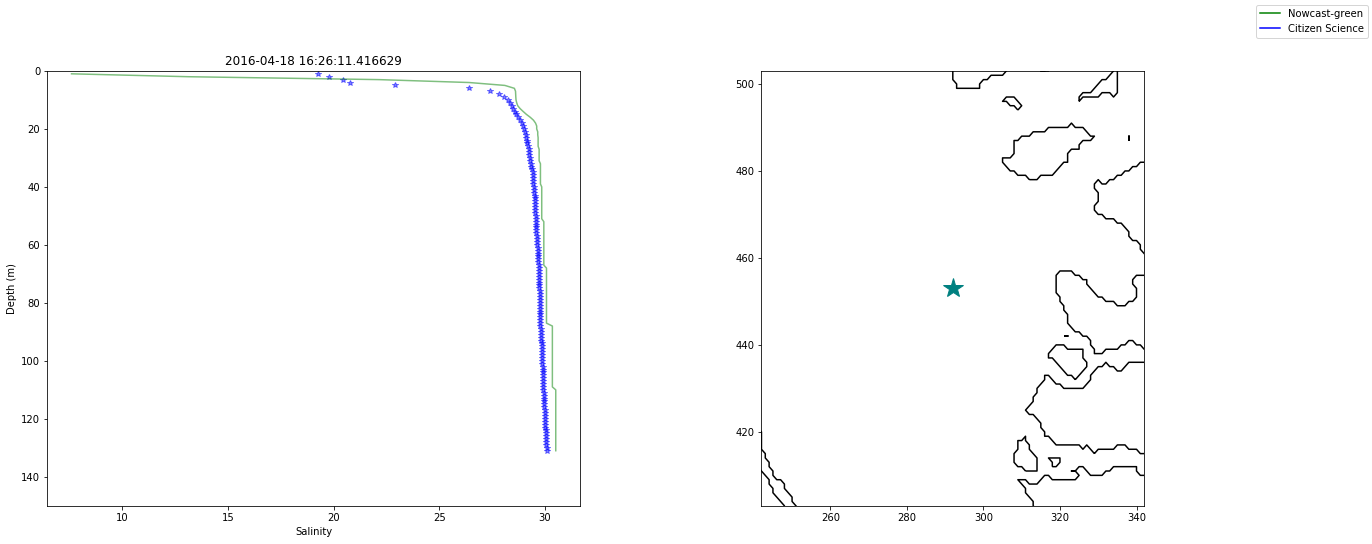

In [84]:
for index in stations:
    compare_one_day(stationdata.iloc[[index]])

In [85]:
stations = np.random.choice(stevestons_stations[:93], size = (5, ))

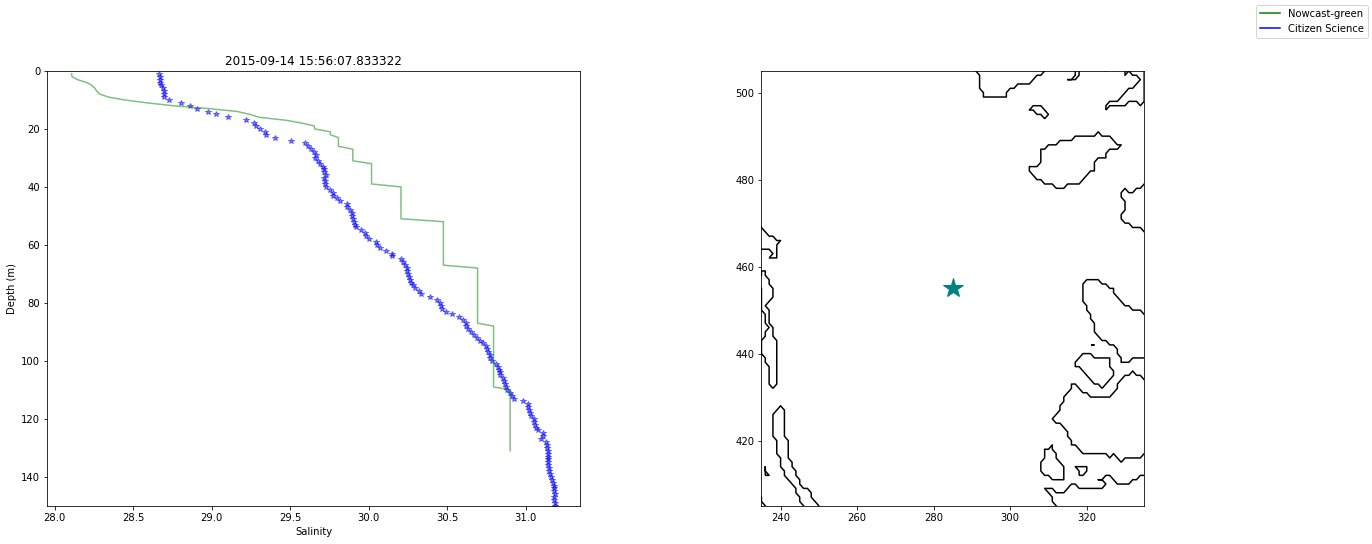

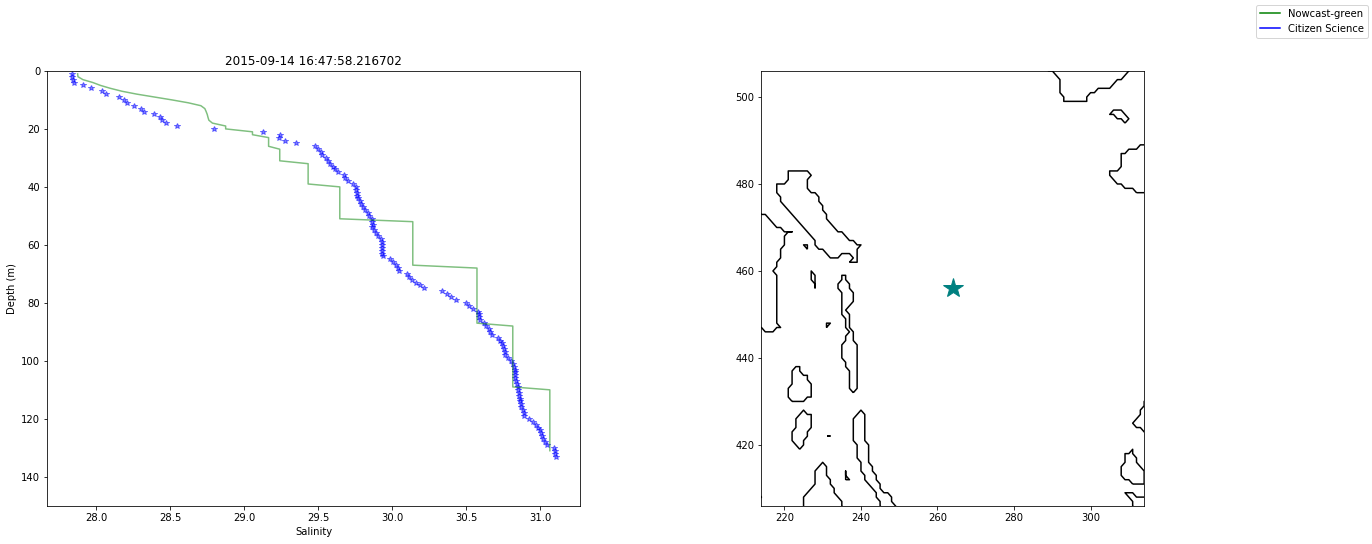

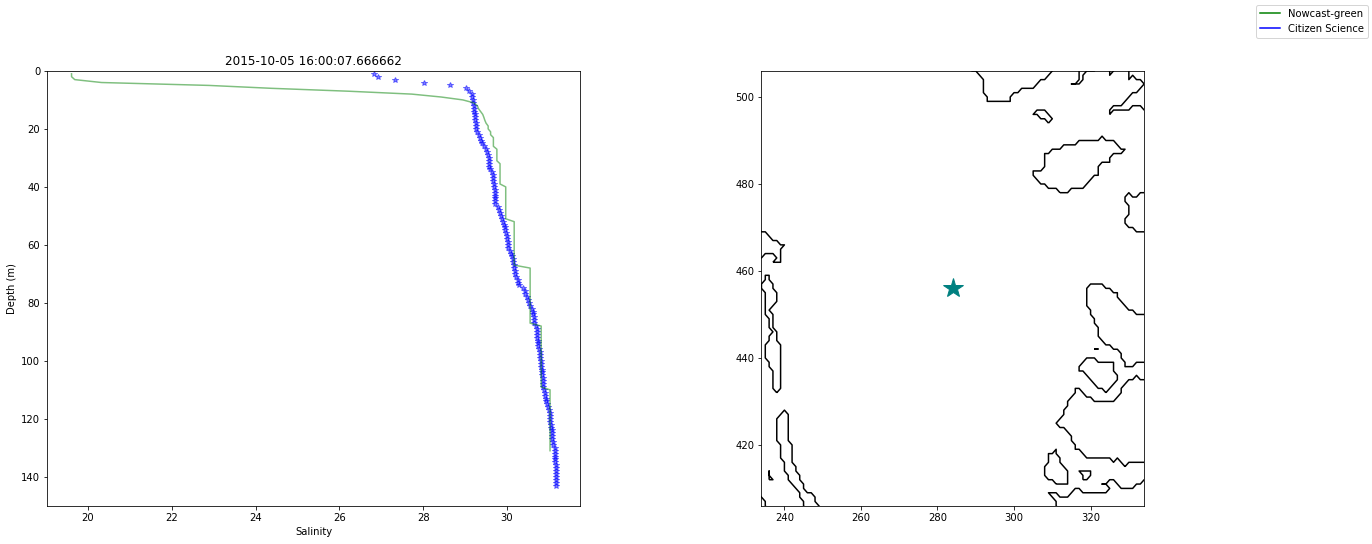

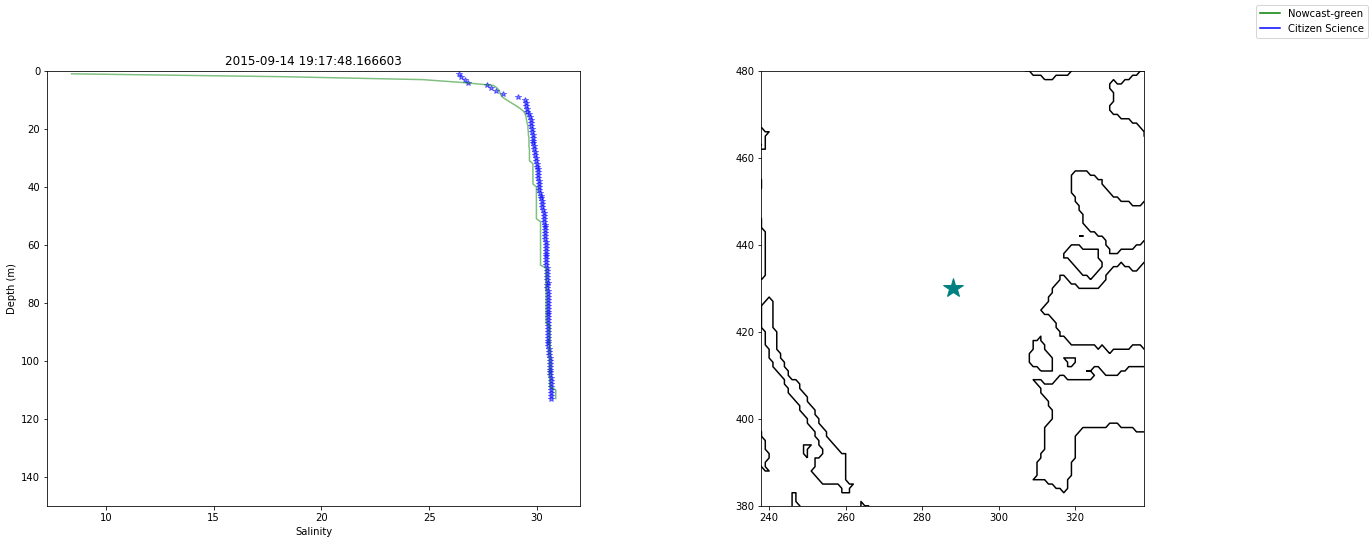

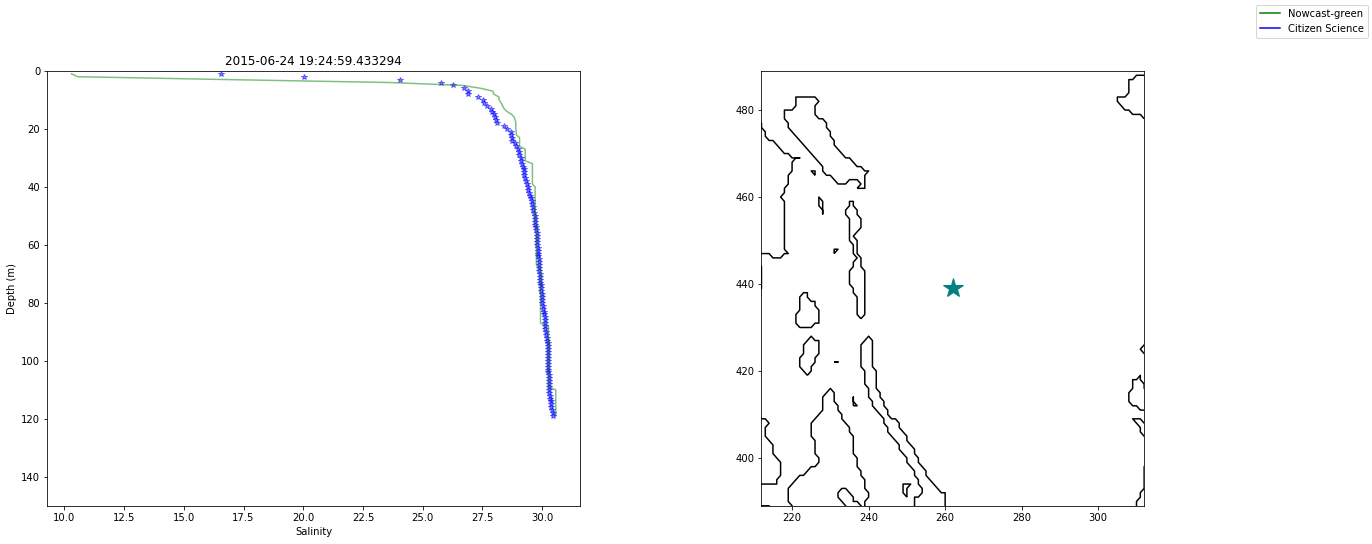

In [86]:
for index in stations:
    compare_one_day(stationdata.iloc[[index]])

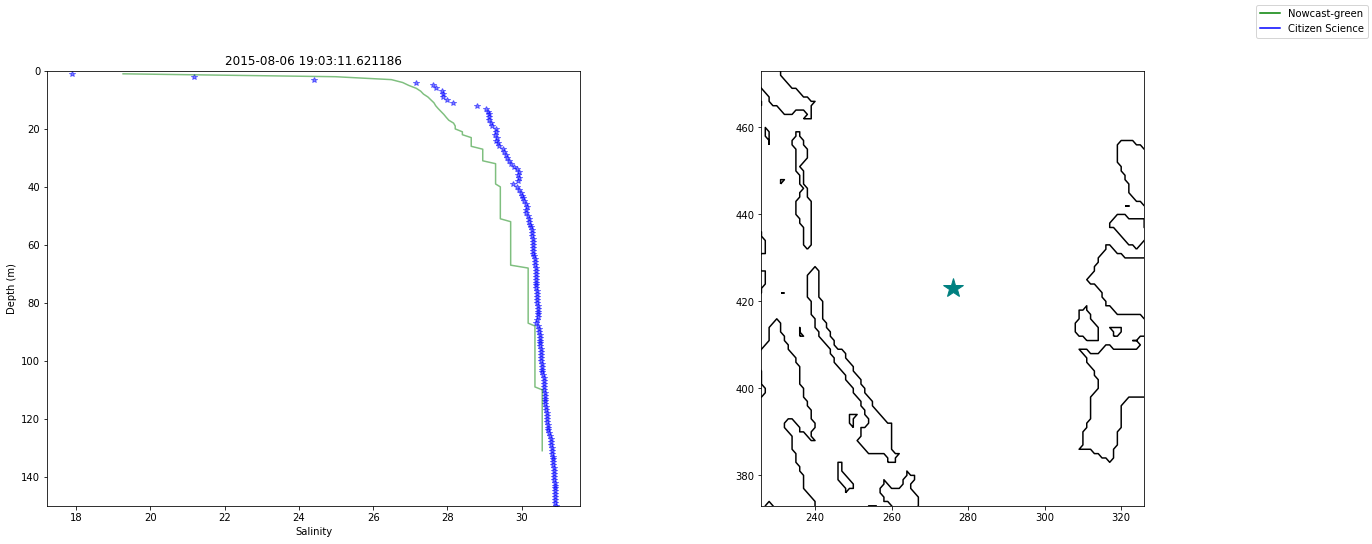

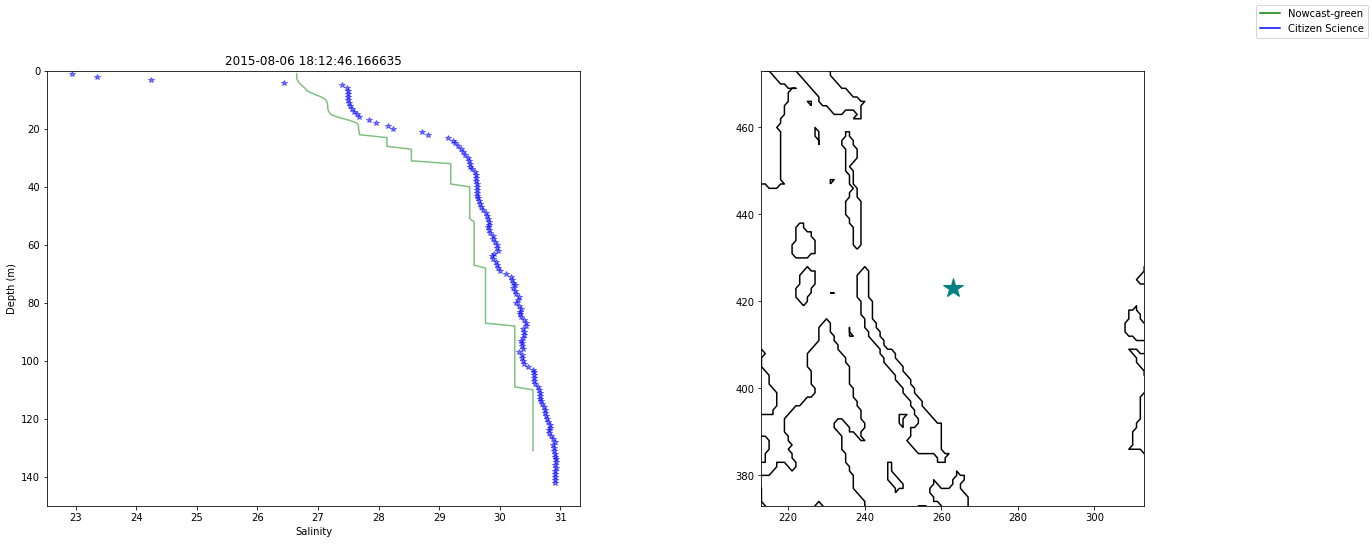

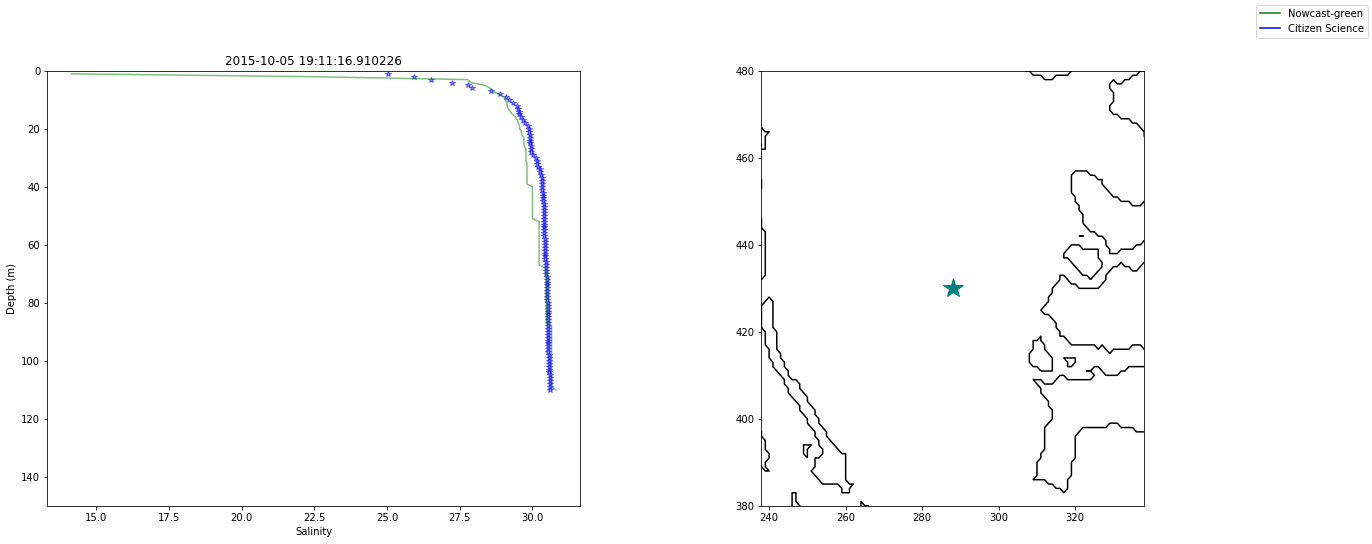

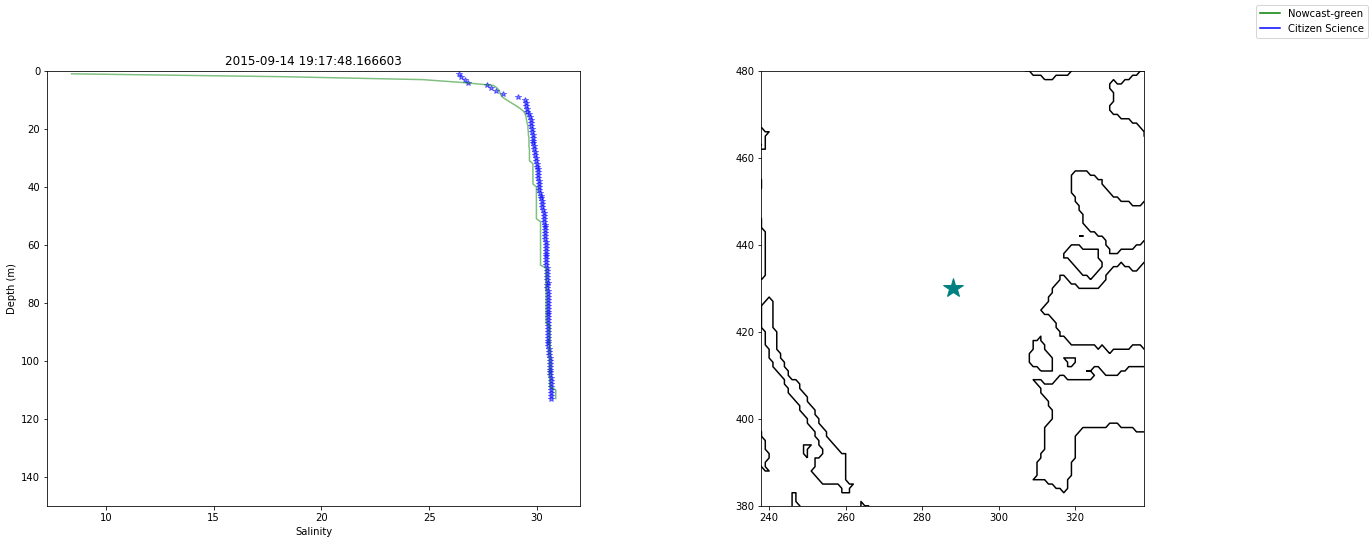

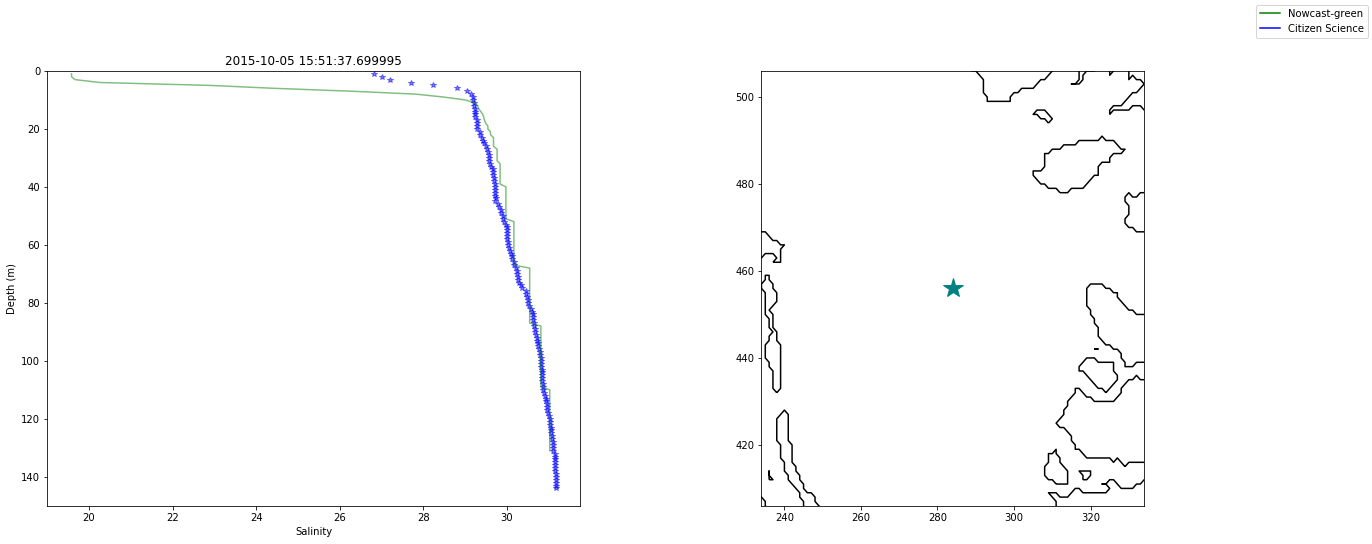

In [87]:
stations = np.random.choice(stevestons_stations[:93], size = (5, ))
for index in stations:
    compare_one_day(stationdata.iloc[[index]])